In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency t
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import pickle
from collections import defaultdict
import random
import statistics as st #for the mode
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
#repeated measures correlation
import pingouin as pg

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, ts_visual, correct_key, chi2_distance, most_frequent
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_binmn = config.li_binmn
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
path_extracted_data_visual_adap_clustering = os.path.join(path_extracted_data_visual_adap,'clustering')
for nbr_bin in li_binmn:
    path_extracted_data_visual_adap_binmn = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability',str(nbr_bin))
    #create a director if not existing
    if not os.path.exists(path_extracted_data_visual_adap_binmn):
        os.makedirs(path_extracted_data_visual_adap_binmn)

change the configuration file if not done yet!


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
li_nbr_cluster = range(2,100)
V = 'chi2distance_ALL_15'
name_clustering = 'ALL_MLPS_99'
path_extracted_data_visual_adap_clustering_V = os.path.join(path_extracted_data_visual_adap_clustering, V+'_ALL_MLPS')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [5]:
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_visual_adap, 'li_selected_hens.pkl'), 'rb'))
print(len(li_selected_hens))
#for now we have only distance restricted to 70 animals
#compute the CHI2DISTANCE & DTW for each bird with all other birds (because we need this exact same pair to do the visual)
#rv = 0
#random.seed(rv)
#nbr_hens = 70
#randomly pick more than one element from the list without repeating elements.
#li_selected_hens = random.sample(li_selected_hens, nbr_hens)

131


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
#HA&KBF&weight
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
print(df_HA.shape)
df_HA = df_HA[df_HA['HenID'].isin(li_selected_hens)]
display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
print(df_HA.shape)
df_HA.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(689, 47)


,HAID,date
0,HA1,{2020-11-23 00:00:00}
1,HA2,{2021-01-04 00:00:00}
2,HA3,{2021-02-01 00:00:00}
3,HA4,{2021-04-12 00:00:00}


(458, 47)


,Person_toe,Time,PenID,FocalLegringName,Bird type,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,initial_path_img,actual_path_img,imageID,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Info,backpack
1,C,08:10,pen11,26grey,NaN,50.0,NaN,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,399.0,493.0,32.0,0.0,26grey11sbs,NaN,"['', '26', 'grey', '11', 'sbs']",sbs
2,C,11:43,pen11,70green,normal,25.0,NaN,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,179.0,478.0,0.0,0.0,70green11gg,NaN,"['', '70', 'green', '11', 'gg']",gg
3,C,08:10,pen11,28green,NaN,0.0,NaN,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,53.0,494.0,12.0,0.0,28green11ss,gap healed no more gap,"['', '28', 'green', '11', 'ss']",ss


In [7]:
df_HA[df_HA['severity'].isnull()]['HAID'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


HA2    115
Name: HAID, dtype: int64

In [8]:
#dailyMVT var
df_MVT = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed_SNA_clID.csv'), sep=';', 
                     parse_dates=['level'], dayfirst=True) 
print(df_MVT.shape)
df_MVT = df_MVT[df_MVT['HenID'].isin(li_selected_hens)]
#lets restrict to the adaptability study timeframe
df_MVT = df_MVT[df_MVT['level']<=config.max_date_adaptability]
print(df_MVT.shape)
df_MVT.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(42300, 223)
(6721, 223)


C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (123,135,172,173,174,175,176,177,179,180,181,182,183,184,185,186,187,188) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,Total_number_zone,Max_duration_zones,...,betweeness_DTW_30_all,degree_DTW_30_1_Zone,degree_DTW_30_2_Zone,degree_DTW_30_3_Zone,degree_DTW_30_4_Zone,degree_DTW_30_5_Zone,degree_DTW_30_all,ALL_MLPS_99,ALL_MLPS_10,ALL_MLPS_40
0,hen_1,2020-09-30,0.0,18886.0,3488.0,515.0,5911.0,28800.0,4.0,2_Zone,...,0.002710,1.000000,0.131944,0.208333,0.826389,0.437500,0.312500,NaN,NaN,NaN
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,3.0,5_Zone,...,0.183609,0.993197,0.047619,0.176871,0.802721,0.115646,0.380952,NaN,NaN,NaN
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,2.0,5_Zone,...,0.000955,1.000000,0.564626,0.646259,0.802721,0.455782,0.503401,NaN,NaN,NaN


In [9]:
#distance measure (chi2, dtw)
#_df_DistanceRoutineDev
df_intra = pd.read_csv(os.path.join(path_extracted_data_visual_adap ,id_run+'_df_DistanceRoutineDev2h-17h59LEVEL.csv'), sep=';', 
                      parse_dates=['level','level+1'], dayfirst=True)
#weeks of age starting on the first day where the bird was here during 24h
df_intra = df_intra[df_intra['is_same_ind']]
df_intra.rename(columns={'henID1':'HenID'}, inplace=True)
df_intra['weeks_in_laying_barn'] = df_intra['DOA'].map(lambda x: int((x-119)/7)+1)
df_intra = df_intra[df_intra['level+1']<=config.max_date_adaptability]
display(df_intra[['level','DOA','weeks_in_laying_barn']].drop_duplicates().reset_index().head(3))
#remove weeks_in_laying_barn to avoid confusions
df_intra.drop(['WOA'], inplace=True, axis=1)
print(df_intra.shape)
df_intra = df_intra[df_intra['HenID'].isin(li_selected_hens)]
df_intra['DTW_15_all'] = df_intra[['DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone']].sum(axis=1)
df_intra['DTW_30_all'] = df_intra[['DTW_30_1_Zone', 'DTW_30_2_Zone', 'DTW_30_3_Zone','DTW_30_4_Zone','DTW_30_5_Zone']].sum(axis=1)
print(df_intra.shape)
df_intra.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,level,DOA,weeks_in_laying_barn
0,0,2020-09-30,119,1
1,2160,2020-10-01,120,1
2,4329,2020-10-02,121,1


(5916, 106)
(5916, 108)


,level,level+1,HenID,henID2,PenID,Treatment,dur_values_normalized_henID1,dur_values_normalized_henID2,chi2distance,DOA,...,nbr_obs_l1_30_1_Zone,nbr_obs_l2_30_1_Zone,is_same_ind,type,HenID1_CLASS,HenID2_CLASS,CLASS,weeks_in_laying_barn,DTW_15_all,DTW_30_all
0,2020-09-30,2020-10-01,hen_102,hen_102,pen3,OFH,"[0.0, 0.010625, 0.19631944444444444, 0.0215625...","[0.0, 0.0, 0.0, 0.0, 1.0]",1.289912e-01,119,...,33,33,True,Intra individuals - OFH,MEXP,MEXP,MEXP,1,184.9,258.0
27,2020-09-30,2020-10-01,hen_32,hen_32,pen5,OFH,"[0.0, 0.8773263888888889, 0.12267361111111111,...","[0.0, 0.8774074074074074, 0.12259259259259259,...",1.525175e-08,119,...,33,33,True,Intra individuals - OFH,EPI,EPI,EPIEPI,1,168.9,238.2
30,2020-09-30,2020-10-01,hen_26,hen_26,pen5,OFH,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.18135802469135803, 0.19959876543209876...",2.352975e-01,119,...,33,33,True,Intra individuals - OFH,LEXP,LEXP,LEXP,1,158.9,220.2


#MSSD (Mean of the squared successive differences)
#It is calculated by taking the sum of the differences between consecutive observations squared, then taking the mean of that sum and dividing by two.
def mssd(li):
    li_diff = [(li[i+1]-li[i])**2 for i in range(0,len(li)-1)]
    return(np.mean(li_diff)/2)
li_distance = ['chi2distance','chi2distance_ALL_15', 'DTW_30_all', 'DTW_30_1_Zone','DTW_30_2_Zone', 'DTW_30_3_Zone', 
               'DTW_30_4_Zone','DTW_30_5_Zone'] 
df_mssd = df_intra.groupby(['HenID'])[li_distance].agg(lambda x: list(x)).reset_index()
df_mssd['nbr_obs'] = df_mssd['DTW_30_5_Zone'].map(lambda x: len(x))
plt.hist(df_mssd['nbr_obs'])
plt.show()
print(df_mssd.shape)
df_mssd = df_mssd[df_mssd['nbr_obs']>=46]
#compute mssd
for dist_type in li_distance:
    df_mssd['mssd_'+dist_type] = df_mssd[dist_type].map(lambda x: mssd(x))
print(df_mssd.shape)
df_mssd.head(3)

# Processing

In [10]:
#make sure np.nan for wintergarten var!!
df_MVT.loc[df_MVT['level']<config.date_first_opening_WG,'percentage_time_outside_while_WG_open'] = np.nan
df_MVT.loc[df_MVT['level']<config.date_first_opening_WG,'latency_1_Zone'] = np.nan
#small check
#df_MVT[df_MVT['HenID']=='hen_10'][['level','duration_5_Zone','percentage_time_outside_while_WG_open','latency_1_Zone']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
#compeck: HA1: as worse time for this
#overall pododeratitis: should be worst over time, so only HA4
df_HA['Injuries'] = df_HA.apply(lambda x: x['LFinjuries']+x['RFinjuries'], axis=1)
df_HA['Pododermatitis'] = df_HA.apply(lambda x: x['RFPododermatitis']+x['LFPododermatitis'], axis=1)

#overall feather as in eneral have the same tendency: only from HA4: as should be worse over time
df_HA['Feathers'] = df_HA.apply(lambda x: np.mean([x['NeckFeather'],x['BreastFeather'],x['CloacaFeather'],
                                                   x['BackFeather'],x['WingFeather'],x['TailFeather']]), axis=1)
display(df_HA[df_HA['Feathers'].isnull()].shape)
display(df_HA[~df_HA['Feathers'].isnull()].shape)
df_HA.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(132, 50)

(326, 50)

,Person_toe,Time,PenID,FocalLegringName,Bird type,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Info,backpack,Injuries,Pododermatitis,Feathers
1,C,08:10,pen11,26grey,NaN,50.0,NaN,0.0,0.0,0.0,...,493.0,32.0,0.0,26grey11sbs,NaN,"['', '26', 'grey', '11', 'sbs']",sbs,0.0,0.0,90.666667
2,C,11:43,pen11,70green,normal,25.0,NaN,0.0,0.0,0.0,...,478.0,0.0,0.0,70green11gg,NaN,"['', '70', 'green', '11', 'gg']",gg,0.0,0.0,NaN
3,C,08:10,pen11,28green,NaN,0.0,NaN,0.0,0.0,0.0,...,494.0,12.0,0.0,28green11ss,gap healed no more gap,"['', '28', 'green', '11', 'ss']",ss,0.0,100.0,94.333333


In [12]:
#add np.nan for the WG var when the WG was close
df_MVT['in_WG_15mnAfterOpening_whenopen'] = df_MVT.apply(lambda x: x['in_WG_15mnAfterOpening'] if x['level']>config.date_first_opening_WG else np.nan, axis=1)
display(df_MVT['in_WG_15mnAfterOpening'].value_counts())
display(df_MVT['in_WG_15mnAfterOpening_whenopen'].value_counts())
df_MVT.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0    5211
1.0    1171
Name: in_WG_15mnAfterOpening, dtype: int64

0.0    4358
1.0    1171
Name: in_WG_15mnAfterOpening_whenopen, dtype: int64

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,Total_number_zone,Max_duration_zones,...,degree_DTW_30_1_Zone,degree_DTW_30_2_Zone,degree_DTW_30_3_Zone,degree_DTW_30_4_Zone,degree_DTW_30_5_Zone,degree_DTW_30_all,ALL_MLPS_99,ALL_MLPS_10,ALL_MLPS_40,in_WG_15mnAfterOpening_whenopen
0,hen_1,2020-09-30,0.0,18886.0,3488.0,515.0,5911.0,28800.0,4.0,2_Zone,...,1.000000,0.131944,0.208333,0.826389,0.437500,0.312500,NaN,NaN,NaN,NaN
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,3.0,5_Zone,...,0.993197,0.047619,0.176871,0.802721,0.115646,0.380952,NaN,NaN,NaN,NaN
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,2.0,5_Zone,...,1.000000,0.564626,0.646259,0.802721,0.455782,0.503401,NaN,NaN,NaN,NaN


In [13]:
#add %of days with no movement on the first 3 days (as after a lot of missing data)
df_nnmvt = df_MVT[df_MVT['DOA'].isin([119,120,121])].groupby(['HenID','PenID'])['Total_number_zone'].agg(lambda x: list(x)).reset_index()
df_nnmvt['nbr_days'] = df_nnmvt['Total_number_zone'].map(lambda x: len(x))
display(df_nnmvt['nbr_days'].value_counts())
df_nnmvt['%_days_nomvt'] = df_nnmvt['Total_number_zone'].map(lambda x: sum([i==1 for i in x])/len(x)*100)
df_nnmvt['veri=1'] = df_nnmvt['Total_number_zone'].map(lambda x: [i==1 for i in x])
display(df_nnmvt.head(3))
dico_henID_daysnomvt = dict(zip(df_nnmvt['HenID'], df_nnmvt['%_days_nomvt']))
#dico_henID_daysnomvt
df_nnmvt['has_nomvt_at_leastoneday'] = df_nnmvt['%_days_nomvt'].map(lambda x: x>0)
df_stat = df_nnmvt.groupby(['PenID'])['has_nomvt_at_leastoneday'].agg(lambda x: list(x)).reset_index()
df_stat['perc_animal_anomvtday'] = df_stat['has_nomvt_at_leastoneday'].map(lambda x: sum(x)/len(x)*100)
df_stat['nbr_animals'] = df_stat['has_nomvt_at_leastoneday'].map(lambda x: len(x))
display(df_stat.head(3))
li_pensvalue = df_stat['perc_animal_anomvtday'].tolist()
print('There is in average %d (+/-%d) percent of animals with at least one of the first three days in the laying barn with no transitions'%(np.mean(li_pensvalue), np.std(li_pensvalue)))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3    131
Name: nbr_days, dtype: int64

,HenID,PenID,Total_number_zone,nbr_days,%_days_nomvt,veri=1
0,hen_1,9.0,"[4.0, 3.0, 2.0]",3,0.000000,"[False, False, False]"
1,hen_10,11.0,"[4.0, 2.0, 1.0]",3,33.333333,"[False, False, True]"
2,hen_101,5.0,"[2.0, 2.0, 3.0]",3,0.000000,"[False, False, False]"


,PenID,has_nomvt_at_leastoneday,perc_animal_anomvtday,nbr_animals
0,3.0,"[True, False, True, False, True, False, False,...",53.333333,15
1,4.0,"[False, False, False, False, True, False, Fals...",12.500000,16
2,5.0,"[False, False, True, False, False, False, True...",43.750000,16


There is in average 36 (+/-11) percent of animals with at least one of the first three days in the laying barn with no transitions


In [14]:
#add %of days with no movement on the first 3 days (as after a lot of missing data)
df_nnmvt = df_MVT[df_MVT['DOA'].isin([149,150,151])].groupby(['HenID','PenID'])['Total_number_zone'].agg(lambda x: list(x)).reset_index()
df_nnmvt['nbr_days'] = df_nnmvt['Total_number_zone'].map(lambda x: len(x))
display(df_nnmvt['nbr_days'].value_counts())
df_nnmvt['%_days_nomvt'] = df_nnmvt['Total_number_zone'].map(lambda x: sum([i==1 for i in x])/len(x)*100)
df_nnmvt['veri=1'] = df_nnmvt['Total_number_zone'].map(lambda x: [i==1 for i in x])
display(df_nnmvt.head(3))
dico_henID_daysnomvt = dict(zip(df_nnmvt['HenID'], df_nnmvt['%_days_nomvt']))
#dico_henID_daysnomvt
df_nnmvt['has_nomvt_at_leastoneday'] = df_nnmvt['%_days_nomvt'].map(lambda x: x>0)
df_stat = df_nnmvt.groupby(['PenID'])['has_nomvt_at_leastoneday'].agg(lambda x: list(x)).reset_index()
df_stat['perc_animal_anomvtday'] = df_stat['has_nomvt_at_leastoneday'].map(lambda x: sum(x)/len(x)*100)
df_stat['nbr_animals'] = df_stat['has_nomvt_at_leastoneday'].map(lambda x: len(x))
display(df_stat.head(3))
li_pensvalue = df_stat['perc_animal_anomvtday'].tolist()
print('There is in average %d (+/-%d) percent of animals with at least one of the 30,31,32 days in the laying barn with no transitions'%(np.mean(li_pensvalue), np.std(li_pensvalue)))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3    130
2      1
Name: nbr_days, dtype: int64

,HenID,PenID,Total_number_zone,nbr_days,%_days_nomvt,veri=1
0,hen_1,9.0,"[2.0, 5.0, 5.0]",3,0.0,"[False, False, False]"
1,hen_10,11.0,"[5.0, 5.0, 4.0]",3,0.0,"[False, False, False]"
2,hen_101,5.0,"[5.0, 5.0, 5.0]",3,0.0,"[False, False, False]"


,PenID,has_nomvt_at_leastoneday,perc_animal_anomvtday,nbr_animals
0,3.0,"[False, False, False, False, False, False, Fal...",0.0,15
1,4.0,"[False, False, False, False, False, False, Fal...",0.0,16
2,5.0,"[False, False, False, False, False, False, Fal...",0.0,16


There is in average 2 (+/-3) percent of animals with at least one of the 30,31,32 days in the laying barn with no transitions


In [15]:
#merge the least frequent clusterID together for now
nbr_cluster2keep = 10
li_clmostimportant = df_MVT['ALL_MLPS_99'].value_counts().reset_index()['index'][0:nbr_cluster2keep].tolist()
df_MVT['ALL_MLPS_99_'+str(nbr_cluster2keep)+'cat'] = df_MVT['ALL_MLPS_99'].map(lambda x: 'clID'+str(int(x)) if x in li_clmostimportant else 'clIDother')
df_MVT['ALL_MLPS_99_'+str(nbr_cluster2keep)+'cat'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


clIDother    2390
clID67       1904
clID22        727
clID3         475
clID15        350
clID0         274
clID6         157
clID7         133
clID21        131
clID52        112
clID33         68
Name: ALL_MLPS_99_10cat, dtype: int64

# Chosing the variables

In [16]:
#print(list(df_MVT.columns))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
dico_h_tr = dict(zip(df_HA['HenID'].tolist(), df_HA['Treatment'].tolist()))
dico_h_HA4sev = dict(zip(df_HA[df_HA['HAID']=='HA4']['HenID'].tolist(), df_HA[df_HA['HAID']=='HA4']['severity'].tolist()))
dico_h_HA4feather = dict(zip(df_HA[df_HA['HAID']=='HA4']['HenID'].tolist(), df_HA[df_HA['HAID']=='HA4']['Feathers'].tolist()))
dico_h_HA4podo = dict(zip(df_HA[df_HA['HAID']=='HA4']['HenID'].tolist(), df_HA[df_HA['HAID']=='HA4']['Pododermatitis'].tolist()))
dico_h_HA4toesinjuries = dict(zip(df_HA[df_HA['HAID']=='HA4']['HenID'].tolist(), df_HA[df_HA['HAID']=='HA4']['Injuries'].tolist()))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
li_mvt4MLPs = ['perc_duration_5_Zone','perc_duration_4_Zone', 'perc_duration_3_Zone', 'perc_duration_2_Zone',
               'percentage_time_outside_while_WG_open', 'latency_1_Zone', 'vertical_travel_distance']
li_ha = ['severity','Feathers','CombPecks']
li_dist = ['chi2distance','chi2distance_ALL_15', 'DTW_30_all', 'DTW_30_1_Zone','DTW_30_2_Zone', 'DTW_30_3_Zone', 
           'DTW_30_4_Zone','DTW_30_5_Zone'] 

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Initial Visuals - quantifying the values through time

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


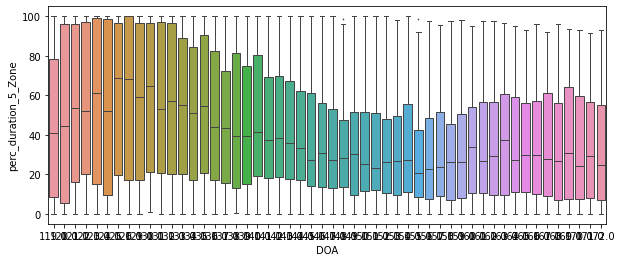

                r   dof           pval           CI95%  power
rm_corr -0.311317  6250  1.436389e-140  [-0.33, -0.29]    1.0


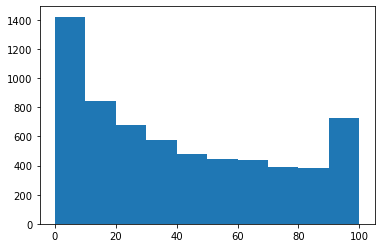

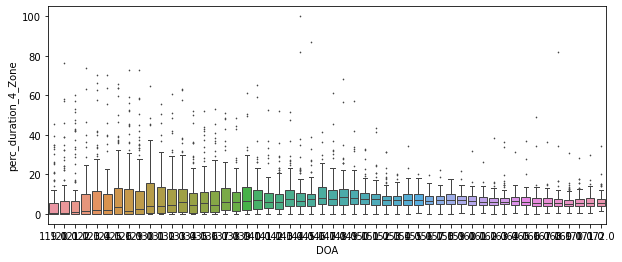

                r   dof          pval           CI95%  power
rm_corr -0.092725  6250  2.040482e-13  [-0.12, -0.07]    1.0


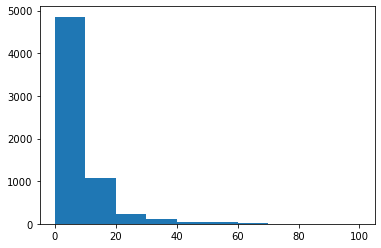

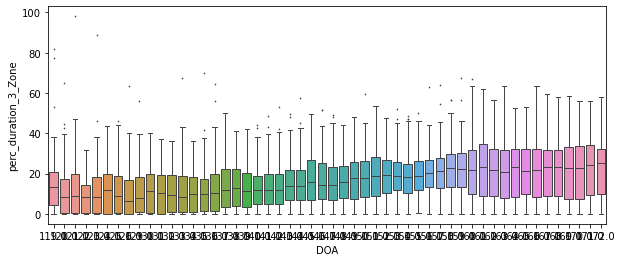

                r   dof           pval         CI95%  power
rm_corr  0.390664  6250  4.555466e-227  [0.37, 0.41]    1.0


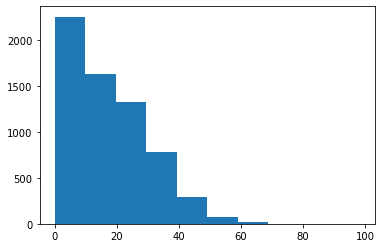

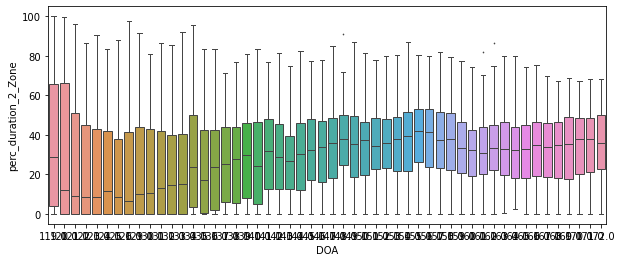

                r   dof          pval         CI95%  power
rm_corr  0.199345  6250  4.679914e-57  [0.18, 0.22]    1.0


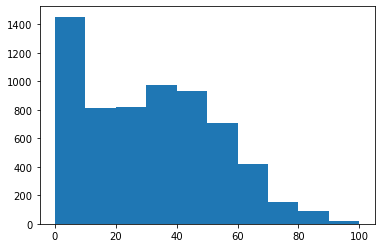

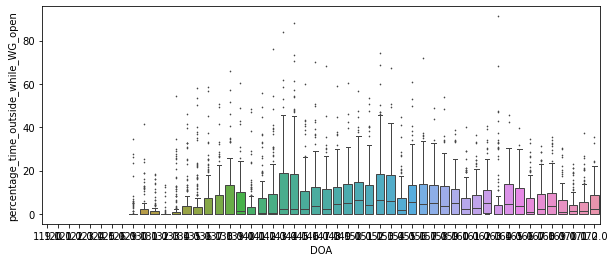

                r   dof      pval         CI95%     power
rm_corr  0.038155  5397  0.005048  [0.01, 0.06]  0.800787


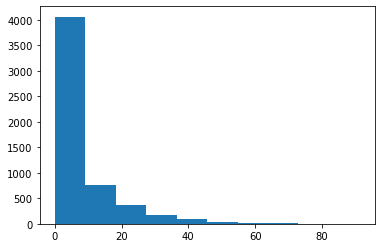

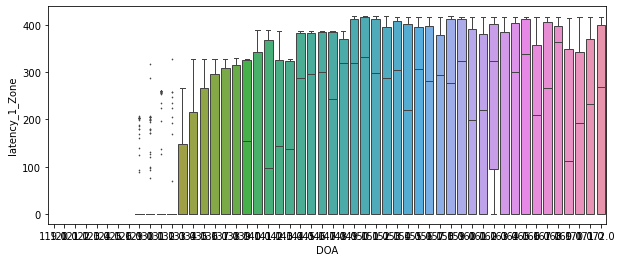

                r   dof           pval         CI95%  power
rm_corr  0.351661  5541  4.469672e-161  [0.33, 0.37]    1.0


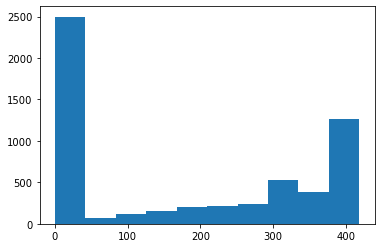

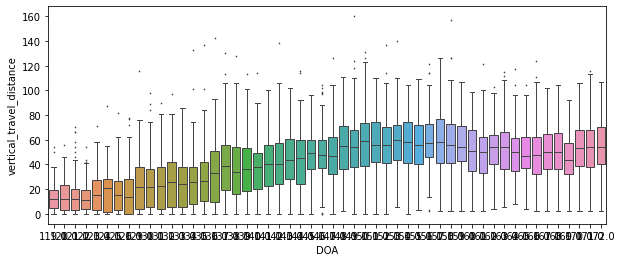

                r   dof  pval         CI95%  power
rm_corr  0.566273  6250   0.0  [0.55, 0.58]    1.0


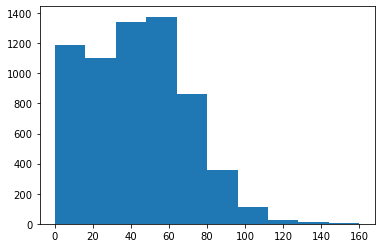

In [19]:
for t in li_mvt4MLPs:
    fig = plt.figure(figsize=(10, 4))
    sns.boxplot(x="DOA", y=t, data=df_MVT, fliersize=0.8, linewidth=1);
    plt.show()
    print(pg.rm_corr(data=df_MVT, x='DOA', y=t, subject='HenID'))
    plt.hist(df_MVT[t])
    #g = pg.plot_rm_corr(data=df_MVT, x='DOA', y=t, subject='HenID')

df_plt = df_intra.copy()
df_plt['treatment'] = df_plt['HenID'].map(lambda x: dico_h_tr.get(x,np.nan))
for dist_ in li_dist[4:]: 
    sns.lineplot(x='DOA',y=dist_,data=df_plt, hue='HenID')
    plt.show()
    sys.exit()

# MLP ~ HA (one obs per hen)

In [20]:
df_AdaptIndicator_ = pd.merge(df_MVT, df_intra, on=['HenID','level'], how='outer')
print(df_AdaptIndicator_.shape, df_MVT.shape, df_intra.shape)
df_AdaptIndicator_ = df_AdaptIndicator_.sort_values(['level'], ascending=True)
df_AdaptIndicator_.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(6721, 331) (6721, 225) (5916, 108)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,Total_number_zone,Max_duration_zones,...,nbr_obs_l1_30_1_Zone,nbr_obs_l2_30_1_Zone,is_same_ind,type,HenID1_CLASS,HenID2_CLASS,CLASS_y,weeks_in_laying_barn_y,DTW_15_all,DTW_30_all
0,hen_1,2020-09-30,0.0,18886.0,3488.0,515.0,5911.0,28800.0,4.0,2_Zone,...,33.0,33.0,True,Intra individuals - OFH,EPI,EPI,EPIEPI,1.0,255.2,353.2
509,hen_109,2020-09-30,0.0,24375.0,4425.0,0.0,0.0,28800.0,2.0,2_Zone,...,33.0,33.0,True,Intra individuals - OFH,MEXP,MEXP,MEXP,1.0,267.8,379.3
712,hen_113,2020-09-30,0.0,22597.0,6203.0,0.0,0.0,28800.0,2.0,2_Zone,...,33.0,33.0,True,Intra individuals - OFH,EPI,EPI,EPIEPI,1.0,312.8,432.0


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


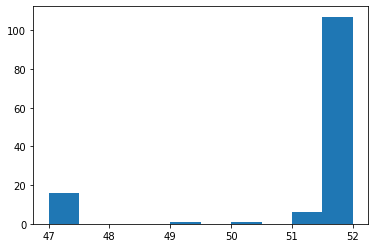

(131, 17)
(131, 62)


,HenID,chi2distance,chi2distance_ALL_15,DTW_30_all,DTW_30_1_Zone,DTW_30_2_Zone,DTW_30_3_Zone,DTW_30_4_Zone,DTW_30_5_Zone,perc_duration_5_Zone,...,mean_percentage_time_outside_while_WG_open,nbr_obs_percentage_time_outside_while_WG_open,mssd_latency_1_Zone,mean_latency_1_Zone,nbr_obs_latency_1_Zone,mssd_vertical_travel_distance,mean_vertical_travel_distance,nbr_obs_vertical_travel_distance,severity,Feathers
0,hen_10,"[0.8962538322278681, 0.04541421311557543, nan,...","[0.9510005239912088, 0.4746503616992918, nan, ...","[393.6, 254.5, nan, nan, 264.1, 343.3, 261.3, ...","[0.0, 0.0, nan, nan, 0.0, 0.0, 0.0, nan, 0.0, ...","[74.3, 0.0, nan, nan, 0.0, 60.3, 63.7, nan, 33...","[142.7, 109.0, nan, nan, 120.7, 123.0, 48.4, n...","[15.9, 33.9, nan, nan, 21.1, 30.0, 59.5, nan, ...","[160.7, 111.6, nan, nan, 122.3, 130.0, 89.7, n...","[2.5451388888888893, 91.31172839506172, 100.0,...",...,0.852542,44,7570.506644,86.386742,44,47.520408,20.980392,51,38.0,82.500000
1,hen_101,"[0.0001232610510278481, 0.0023991954949320327,...","[0.11524405219292785, 0.5558719633263073, 0.14...","[89.0, 229.6, 92.9, 111.2, nan, nan, 287.2, na...","[0.0, 0.0, 0.0, 0.0, nan, nan, 0.0, nan, nan, ...","[44.5, 114.8, 41.8, 42.7, nan, nan, 43.7, nan,...","[44.5, 113.8, 24.1, 25.1, nan, nan, 21.0, nan,...","[0.0, 1.0, 1.8, 9.1, nan, nan, 109.8, nan, nan...","[0.0, 0.0, 25.2, 34.3, nan, nan, 112.7, nan, n...","[0.0, 0.0, 0.0, 6.552469135802469, 7.179012345...",...,5.919845,36,11901.447237,204.273504,39,208.200000,48.186047,43,12.0,88.333333
2,hen_102,"[0.12899116015451198, 0.0, 0.0, 0.040462427744...","[0.5508957986392512, 0.0, 0.0, 0.0400873818314...","[258.0, 0.0, 0.0, 67.2, nan, nan, 0.0, nan, na...","[0.0, 0.0, 0.0, 0.0, nan, nan, 0.0, nan, nan, ...","[5.1, 0.0, 0.0, 0.0, nan, nan, 0.0, nan, nan, ...","[122.1, 0.0, 0.0, 4.7, nan, nan, 0.0, nan, nan...","[10.4, 0.0, 0.0, 30.6, nan, nan, 0.0, nan, nan...","[120.4, 0.0, 0.0, 31.9, nan, nan, 0.0, nan, na...","[77.14930555555556, 100.0, 100.0, 100.0, 91.76...",...,2.397730,41,5259.006948,122.548485,44,23.911111,10.833333,48,54.0,77.833333


(98, 65)
(98, 65)


In [21]:
#MSSD (Mean of the squared successive differences)
#It is calculated by taking the sum of the differences between consecutive observations squared, then taking the mean of that sum and dividing by two.
def mssd(li, maxnbr_nan=None):
    li_diff = [(li[i+1]-li[i])**2 for i in range(0,len(li)-1) if (math.isnan(li[i+1])==False)&(math.isnan(li[i])==False)]
    #return NA if to many nan
    if maxnbr_nan!=None:
        if (len(li)-len(li_diff))>=maxnbr_nan:
            return(np.nan)
    return(np.mean(li_diff)/2)
li_var = li_dist + li_mvt4MLPs
df_AdaptIndicator = df_AdaptIndicator_.groupby(['HenID'])[li_var].agg(lambda x: list(x)).reset_index()
df_AdaptIndicator['nbr_obs'] = df_AdaptIndicator[li_var[0]].map(lambda x: len(x))
plt.hist(df_AdaptIndicator['nbr_obs'])
plt.show()
print(df_AdaptIndicator.shape)
#df_AdaptIndicator = df_AdaptIndicator[df_AdaptIndicator['nbr_obs']>=52]
#compute mssd and the mean
for var in li_var:
    df_AdaptIndicator['mssd_'+var] = df_AdaptIndicator[var].map(lambda x: mssd(x))
    df_AdaptIndicator['mean_'+var] = df_AdaptIndicator[var].map(lambda x: np.nanmean(x))
    df_AdaptIndicator['nbr_obs_'+var] = df_AdaptIndicator[var].map(lambda x: len([i for i in x if not math.isnan(i)]))

print(df_AdaptIndicator.shape)
#add HA results
df_AdaptIndicator = pd.merge(df_AdaptIndicator, df_HA[df_HA['HAID']=='HA4'][['HenID','severity','Feathers']], on=['HenID'], how='inner')
#TODO: verify nan impact! if bais the results!!!!
display(df_AdaptIndicator.head(3))
#add%days no moving among the first 3 days
df_AdaptIndicator['perc_days_nomvtamngfirst3days'] = df_AdaptIndicator['HenID'].map(lambda x: dico_henID_daysnomvt.get(x,np.nan))
#remove hens with no data on first three days
print(df_AdaptIndicator.shape)
df_AdaptIndicator = df_AdaptIndicator[~df_AdaptIndicator['perc_days_nomvtamngfirst3days'].isnull()]
print(df_AdaptIndicator.shape)
#save
df_AdaptIndicator.to_csv(os.path.join(path_extracted_data ,'Adaptability_Stat_MSSD_mixedeffect.csv'), index=False, sep=';')
#df_AdaptIndicator[[x for x in df_AdaptIndicator.columns if x.startswith('mssd')|(x.startswith('mean'))]+['severity','Feathers','perc_days_nomvtamngfirst3days']].to_csv(os.path.join(path_extracted_data ,'Adaptability_Stat_MSSD_mixedeffect_R.csv'), index=False, sep=';')

In [22]:
df_AdaptIndicator[['HenID','mean_percentage_time_outside_while_WG_open','nbr_obs_percentage_time_outside_while_WG_open']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,mean_percentage_time_outside_while_WG_open,nbr_obs_percentage_time_outside_while_WG_open
0,hen_10,0.852542,44
1,hen_101,5.919845,36
2,hen_102,2.397730,41


In [23]:
df_AdaptIndicator[['mean_latency_1_Zone', 'perc_days_nomvtamngfirst3days', 
                   'mean_DTW_30_3_Zone','mssd_DTW_30_3_Zone', 
                   'mean_DTW_30_5_Zone', 'mssd_DTW_30_5_Zone',
                   'mssd_vertical_travel_distance', 'mean_vertical_travel_distance']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,mean_latency_1_Zone,perc_days_nomvtamngfirst3days,mean_DTW_30_3_Zone,mssd_DTW_30_3_Zone,mean_DTW_30_5_Zone,mssd_DTW_30_5_Zone,mssd_vertical_travel_distance,mean_vertical_travel_distance
0,86.386742,0.0,59.827083,496.547222,81.627083,1057.939889,47.520408,20.980392
1,204.273504,0.0,44.197368,351.926471,51.513158,218.857059,208.200000,48.186047
2,122.548485,0.0,22.556818,494.979024,44.350000,597.982561,23.911111,10.833333


# MLP ~ MLPS on day 172

In [24]:
#!!    copy paste from: https://gist.github.com/zhiyzuo/d38159a7c48b575af3e3de7501462e04     !!
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
df_pivot

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DOA,HenID,119.0,120.0,121.0,122.0,123.0,124.0,125.0,126.0,129.0,...,163.0,164.0,165.0,166.0,167.0,168.0,169.0,170.0,171.0,172.0
0,hen_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,68.277778,26.884615,25.779279,26.934211,24.949074,17.177215,21.901709,21.098291,15.773663,20.872428
1,hen_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,1.474359,4.828829,1.416667,3.416667,0.000000,0.000000,0.303419,3.423868,1.374486
2,hen_101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.277778,0.000000,0.000000,0.000000,1.551440,1.222222
3,hen_102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,7.435897,1.504505,2.342105,4.912037,6.021097,1.384615,3.662393,17.193416,9.020576
4,hen_103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,5.722222,15.170940,12.792793,9.837719,14.833333,3.717300,1.132479,13.773504,12.683128,10.139918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,hen_94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,30.444444,20.730769,23.445946,12.289474,9.277778,9.649789,2.743590,3.474359,5.740741,4.925926
127,hen_95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.621795,...,0.000000,5.547009,0.000000,2.495614,4.324074,7.434599,10.354701,3.747863,6.427984,6.094650
128,hen_97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
129,hen_98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.283784,0.000000,0.939815,0.320675,1.363248,0.354701,0.000000,0.000000


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


------------------------------------------ perc_duration_5_Zone
------------------------------------------ perc_duration_4_Zone
------------------------------------------ perc_duration_3_Zone
------------------------------------------ perc_duration_2_Zone
------------------------------------------ percentage_time_outside_while_WG_open
------------------------------------------ latency_1_Zone
------------------------------------------ vertical_travel_distance
(334, 21)


,coeff,p_val,d1,d2,type_,nbr_obs,L,H,verif,coeff_o,...,coeff_t,p_val_t,coeffHAsev,p_valHAsev,coeffHAf,p_valHAf,coeffHApodo,p_valHApodo,coeffHAinj,p_valHAinj
0,0.067327,0.446600,119,172,perc_duration_5_Zone,130,-0.106089,0.236768,"(0.0673269435245862, 0.4466001153672843)",0.070263,...,0.099425,0.430699,-0.011052,0.913986,-0.056574,0.580047,-0.001136,0.991143,0.022926,0.822697
1,0.098586,0.264458,120,172,perc_duration_5_Zone,130,-0.074871,0.266252,"(0.09858583618818836, 0.26445807190845383)",0.100669,...,0.090779,0.472037,0.118406,0.245556,-0.019594,0.848132,-0.031560,0.757701,0.017640,0.863125
2,0.138001,0.117407,121,172,perc_duration_5_Zone,130,-0.035018,0.302987,"(0.13800050288954582, 0.11740659563192163)",0.132744,...,0.138048,0.272797,0.056789,0.578609,-0.014121,0.890239,0.039525,0.699193,0.083837,0.411796
3,0.142273,0.340098,122,172,perc_duration_5_Zone,47,-0.151066,0.412583,"(0.1422725134950551, 0.34009815620674744)",0.230405,...,-0.372791,0.155003,0.188783,0.270169,0.180081,0.293270,0.100836,0.558440,0.105198,0.541457
4,0.220310,0.029270,123,172,perc_duration_5_Zone,98,0.022890,0.401193,"(0.22031031958848885, 0.029269627755752127)",0.187396,...,0.225854,0.118664,-0.063692,0.589803,-0.051686,0.661865,-0.016861,0.886616,-0.093856,0.426385


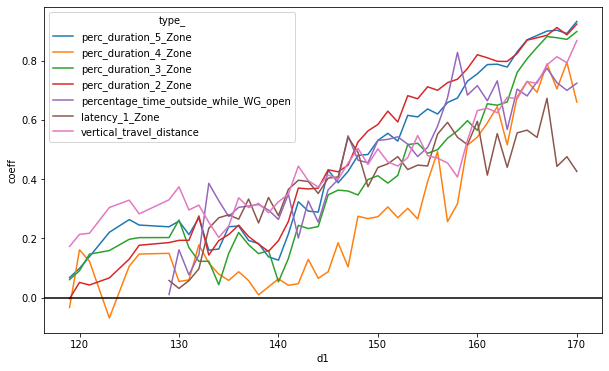

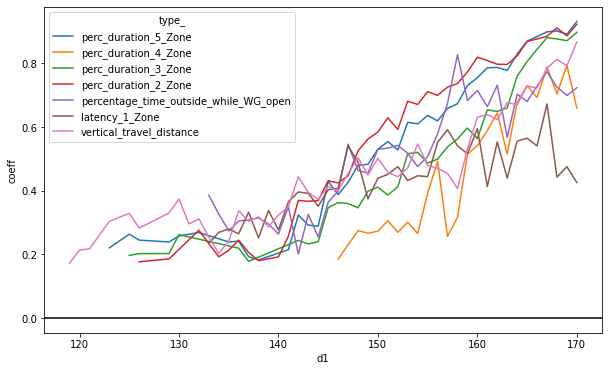

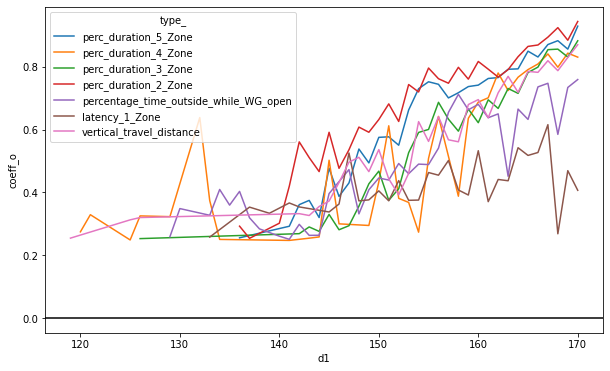

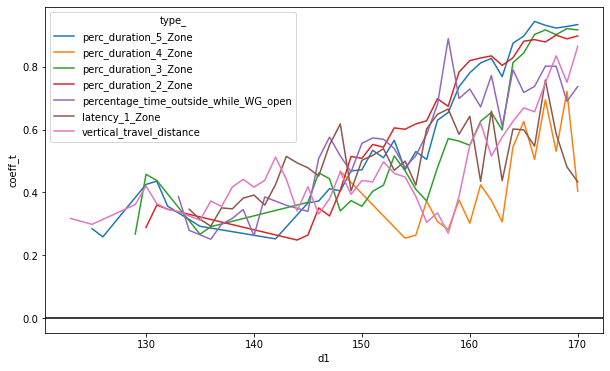

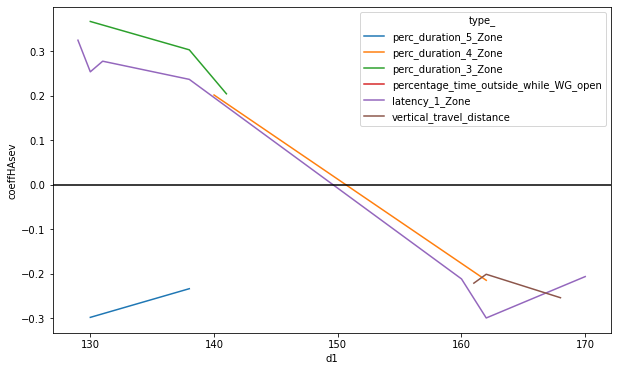

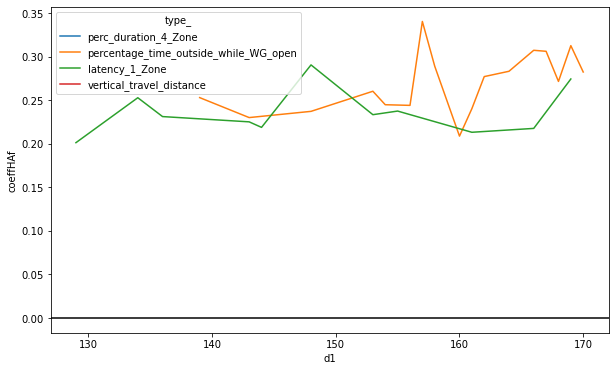

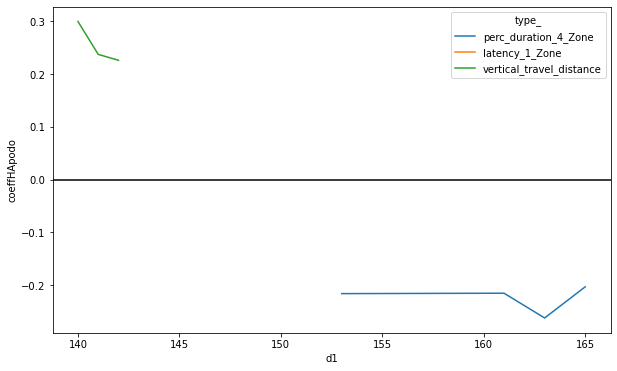

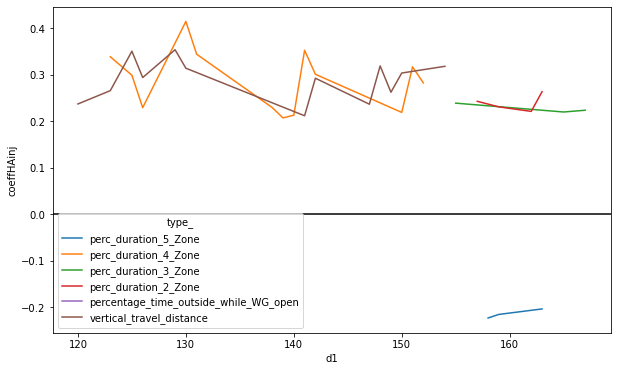

In [32]:
d2 = 172
#coeff, p-val
li = []
for type_ in li_mvt4MLPs:
    df_pivot = df_MVT.pivot(index='HenID', values=type_, columns='DOA').reset_index()
    for d1 in range(119,d2-1):
        if d1 in df_MVT['DOA'].unique():
            #display(df_.head(3))
            #print(df_.shape)
            df_ = df_pivot.copy()
            df_ = df_.dropna(subset=[d1,d2])
            #for some variables, as WG, there is only NA, so no dataframe
            if df_.shape[0]>0:
                df_['treatment'] = df_['HenID'].map(lambda x: dico_h_tr.get(x,np.nan))
                #print(df_.shape)
                #plt.plot(df_[d1], df_[d2], 'ro');
                coeff, p_val = pearsonr(df_[d1].tolist(), df_[d2].tolist())
                coeff_o, p_val_o = pearsonr(df_[df_['treatment']=='OFH'][d1].tolist(), df_[df_['treatment']=='OFH'][d2].tolist())
                coeff_t, p_val_t = pearsonr(df_[df_['treatment']=='TRAN'][d1].tolist(), df_[df_['treatment']=='TRAN'][d2].tolist())

                #HA severity
                df_['severity_HA4'] = df_['HenID'].map(lambda x: dico_h_HA4sev.get(x,np.nan))
                df_HA_ = df_.dropna(subset=['severity_HA4'])
                coeffHAsev, p_valHAsev = pearsonr(df_HA_[d1].tolist(), df_HA_['severity_HA4'].tolist())

                #HA feathers
                df_['feathers_HA4'] = df_['HenID'].map(lambda x: dico_h_HA4feather.get(x,np.nan))
                df_HA_ = df_.dropna(subset=['feathers_HA4'])
                coeffHAf, p_valHAf = pearsonr(df_HA_[d1].tolist(), df_HA_['feathers_HA4'].tolist())

                #HA pododermatits
                df_['podo_HA4'] = df_['HenID'].map(lambda x: dico_h_HA4podo.get(x,np.nan))
                df_HA_ = df_.dropna(subset=['podo_HA4'])
                coeffHApodo, p_valHApodo = pearsonr(df_HA_[d1].tolist(), df_HA_['podo_HA4'].tolist())  

                #HA toes injuries
                df_['injuries_HA4'] = df_['HenID'].map(lambda x: dico_h_HA4toesinjuries.get(x,np.nan))
                df_HA_ = df_.dropna(subset=['injuries_HA4'])
                coeffHAinj, p_valHAinj = pearsonr(df_HA_[d1].tolist(), df_HA_['injuries_HA4'].tolist())            

                #MLPs IC
                #plt.title(type_)
                #plt.show();
                r, p, lo, hi = pearsonr_ci(np.array(df_[d1].tolist()), np.array(df_[d2].tolist()))

                #attention: take into account nan in HA to in the nbr_obs
                li.append({'coeff':coeff, 'p_val':p_val, 'd1':d1, 'd2':d2, 'type_':type_,'nbr_obs':df_.shape[0],'L':lo,
                          'H':hi,'verif':(r,p), 'coeff_o':coeff_o, 'p_val_o':p_val_o, 'coeff_t':coeff_t, 'p_val_t':p_val_t,
                          'coeffHAsev':coeffHAsev, 'p_valHAsev':p_valHAsev,
                          'coeffHAf':coeffHAf, 'p_valHAf':p_valHAf,
                          'coeffHApodo':coeffHApodo, 'p_valHApodo':p_valHApodo,
                          'coeffHAinj':coeffHAinj, 'p_valHAinj':p_valHAinj})
df_corr_res = pd.DataFrame(li)
print(df_corr_res.shape)
display(df_corr_res.head(5))
df_plt = df_corr_res[df_corr_res['nbr_obs']>=80].copy()
#future MLPs alltreatment
fig = plt.figure(figsize=(10, 6))
graph = sns.lineplot(x='d1',y='coeff',hue='type_',data=df_plt);
graph.axhline(0, color='black')
plt.savefig(os.path.join(path_extracted_data, 'Predictibility_behaviouralVariables.png'), dpi=300,
            format='png',bbox_inches='tight')
plt.show()
#HA
for coeff,pval in zip(['coeff','coeff_o','coeff_t','coeffHAsev','coeffHAf','coeffHApodo','coeffHAinj'],
                      ['p_val','p_val_o','p_val_t','p_valHAsev','p_valHAf','p_valHApodo','p_valHAinj']):
    fig = plt.figure(figsize=(10, 6))
    graph = sns.lineplot(x='d1', y=coeff, hue='type_', data=df_plt[df_plt[pval]<0.05]); 
    graph.axhline(0, color='black')
    plt.savefig(os.path.join(path_extracted_data, 'Predictibility_HA'+coeff+'.png'), dpi=300,
                format='png',bbox_inches='tight')
    plt.show()

In [33]:
df_corr_res[df_corr_res['d1']==119]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,coeff,p_val,d1,d2,type_,nbr_obs,L,H,verif,coeff_o,...,coeff_t,p_val_t,coeffHAsev,p_valHAsev,coeffHAf,p_valHAf,coeffHApodo,p_valHApodo,coeffHAinj,p_valHAinj
0,0.067327,0.446600,119,172,perc_duration_5_Zone,130,-0.106089,0.236768,"(0.0673269435245862, 0.4466001153672843)",0.070263,...,0.099425,0.430699,-0.011052,0.913986,-0.056574,0.580047,-0.001136,0.991143,0.022926,0.822697
50,-0.033355,0.706366,119,172,perc_duration_4_Zone,130,-0.204368,0.139633,"(-0.033355318685128074, 0.7063661537813398)",-0.085544,...,0.023408,0.853165,0.007352,0.942722,0.034482,0.736058,0.013520,0.894882,0.129595,0.203433
100,0.060391,0.494897,119,172,perc_duration_3_Zone,130,-0.112969,0.230184,"(0.06039143377244567, 0.49489672600613976)",0.099824,...,0.019925,0.874821,0.165791,0.102784,-0.130306,0.200942,-0.033574,0.742768,-0.014572,0.886758
150,-0.003647,0.967148,119,172,perc_duration_2_Zone,130,-0.175723,0.168645,"(-0.003647387352653339, 0.9671483343074597)",-0.046327,...,0.078715,0.533103,-0.052629,0.606782,0.101448,0.320240,0.009618,0.925113,-0.061700,0.546151
284,0.172687,0.049448,119,172,vertical_travel_distance,130,0.000516,0.334915,"(0.1726870064359414, 0.049448423071976354)",0.254345,...,0.083980,0.505983,0.139159,0.171754,0.069969,0.493590,-0.164787,0.104914,0.075042,0.462714


# MLP ~ short-term & long term MLPS 

In [34]:
li_DOA = [int(x) for x in  df_MVT['DOA'].unique()]
li_df = []
li_mvt4MLPs = ['perc_duration_5_Zone','perc_duration_4_Zone', 'perc_duration_3_Zone', 'perc_duration_2_Zone',
               'vertical_travel_distance']
for type_ in tqdm.tqdm(li_mvt4MLPs):
    df_pivot = df_MVT.pivot(index='HenID', values=type_, columns='DOA').reset_index()
    for d1 in range(min(li_DOA),max(li_DOA)-1):
        for d2 in range(d1+1,max(li_DOA)):
            if (d2 in li_DOA)&(d1 in li_DOA):
                df_ = df_pivot.copy()
                df_ = df_.dropna(subset=[d1,d2])
                if df_.shape[0]>80:
                    df_['treatment'] = df_['HenID'].map(lambda x: dico_h_tr.get(x,np.nan))
                    #print(df_.shape)
                    #alltogether
                    coeff, p_val = pearsonr(df_[d1].tolist(), df_[d2].tolist())
                    r, p, lo, hi = pearsonr_ci(np.array(df_[d1].tolist()), np.array(df_[d2].tolist()))
                    li_df.append({'coeff':coeff, 'p_val':p_val, 'd1':d1, 'd2':d2, 'diff':d2-d1,
                                      'type_':type_,'nbr_obs':df_.shape[0],
                                      'L':lo, 'H':hi, 'verif':(r,p),'treatment':'alltogether'})   
                    for tr,df__ in df_.groupby(['treatment']):
                        coeff, p_val = pearsonr(df__[d1].tolist(), df__[d2].tolist())
                        r, p, lo, hi = pearsonr_ci(np.array(df__[d1].tolist()), np.array(df__[d2].tolist()))
                        li_df.append({'coeff':coeff, 'p_val':p_val, 'd1':d1, 'd2':d2, 'diff':d2-d1,
                                      'type_':type_,'nbr_obs':df__.shape[0],
                                      'L':lo, 'H':hi, 'verif':(r,p),'treatment':tr})   
                else:
                    #print('--------------- not enough data')
                    #print(df_.shape)
                    #print(d1,d2)
                    pass
df_corrddx = pd.DataFrame(li_df)
df_corrddx['significant'] = df_corrddx['p_val'].map(lambda x: x<0.05)
print(df_corrddx.shape)
display(df_corrddx.head(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.09s/it]

(17595, 12)


,coeff,p_val,d1,d2,diff,type_,nbr_obs,L,H,verif,treatment,significant
0,0.633003,4.988275e-16,119,120,1,perc_duration_5_Zone,131,0.517686,0.725732,"(0.6330032232487726, 4.988275233839144e-16)",alltogether,True
1,0.593974,1.831806e-07,119,120,1,perc_duration_5_Zone,65,0.409381,0.731850,"(0.5939735855799712, 1.8318060737733754e-07)",OFH,True
2,0.711429,3.096642e-11,119,120,1,perc_duration_5_Zone,65,0.565686,0.814073,"(0.7114287441544904, 3.096642277022792e-11)",TRAN,True
3,0.534531,4.833951e-11,119,121,2,perc_duration_5_Zone,131,0.399647,0.646758,"(0.5345305832278958, 4.8339514254978006e-11)",alltogether,True
4,0.452273,1.553945e-04,119,121,2,perc_duration_5_Zone,65,0.234210,0.627008,"(0.45227338436808484, 0.0001553945428305082)",OFH,True


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


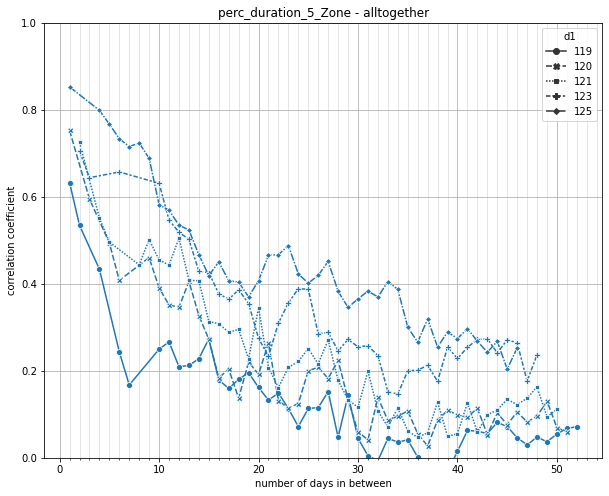

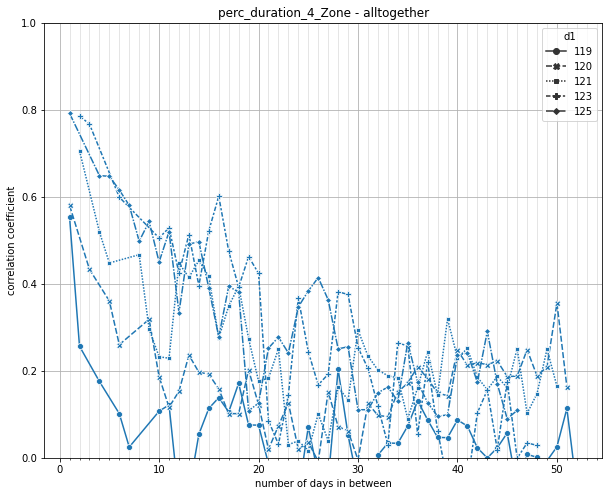

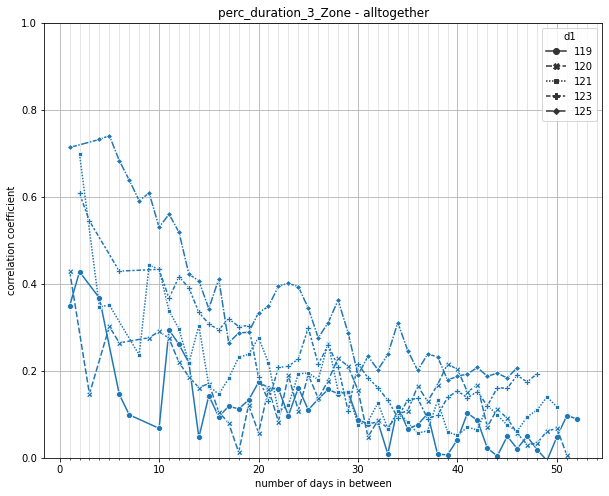

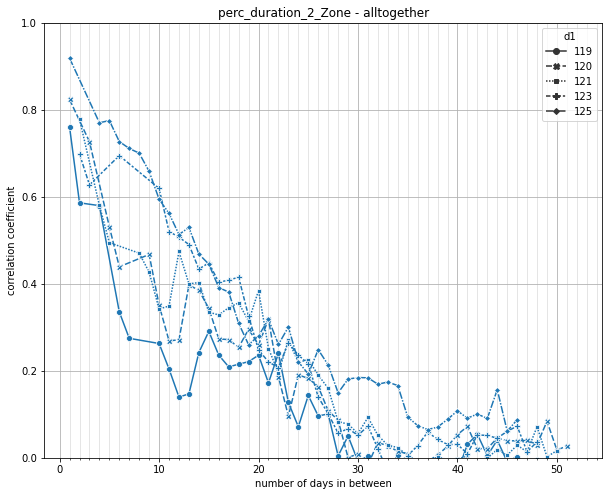

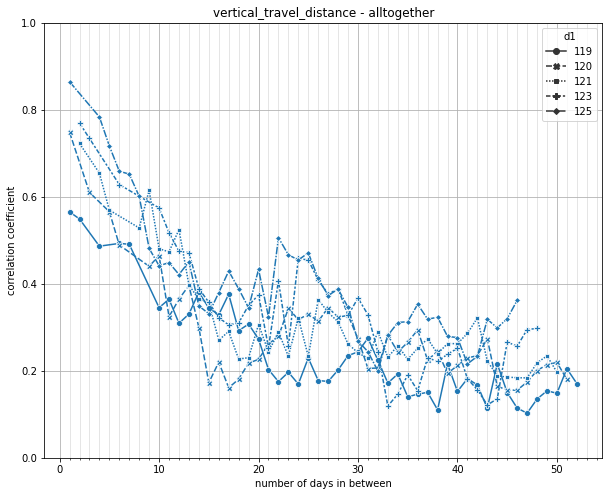

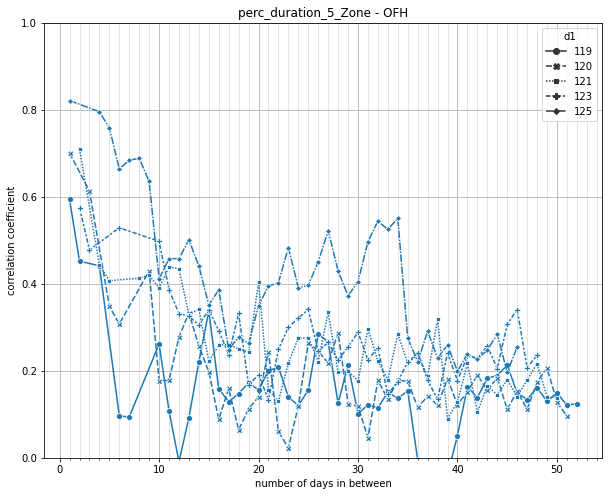

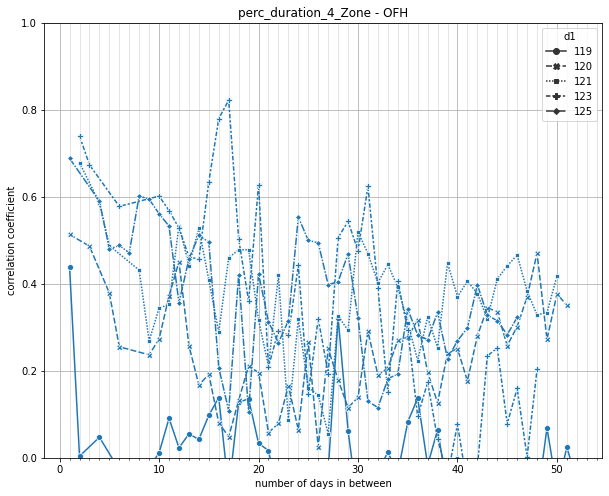

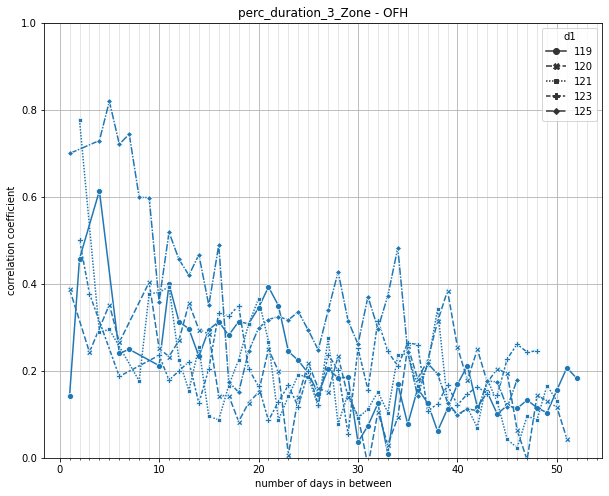

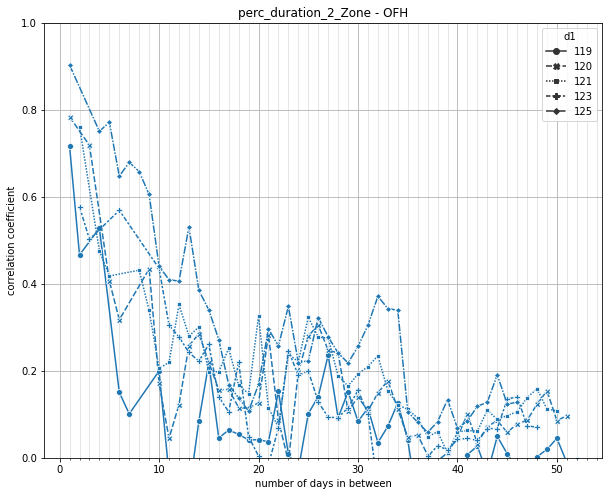

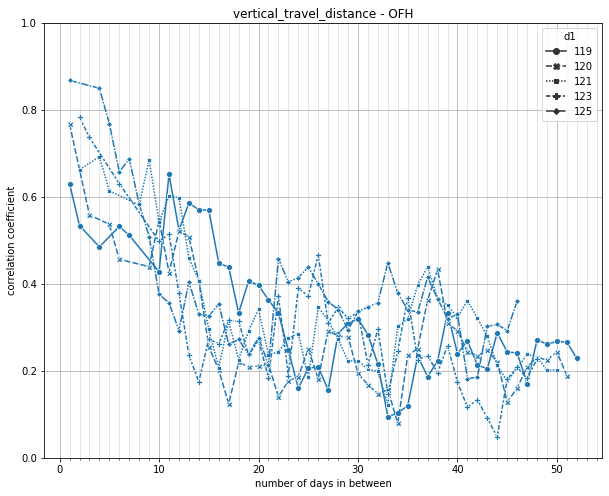

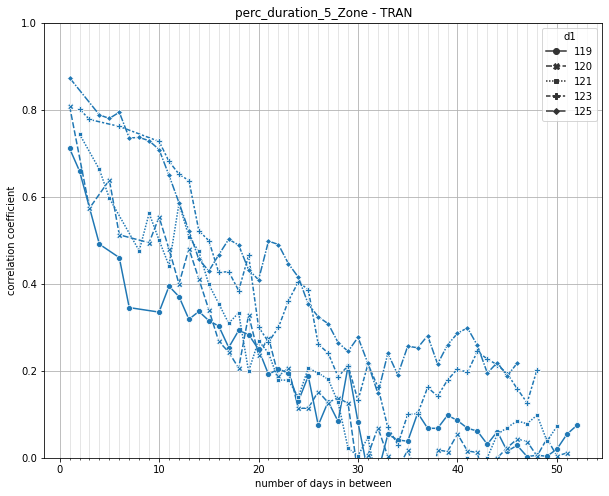

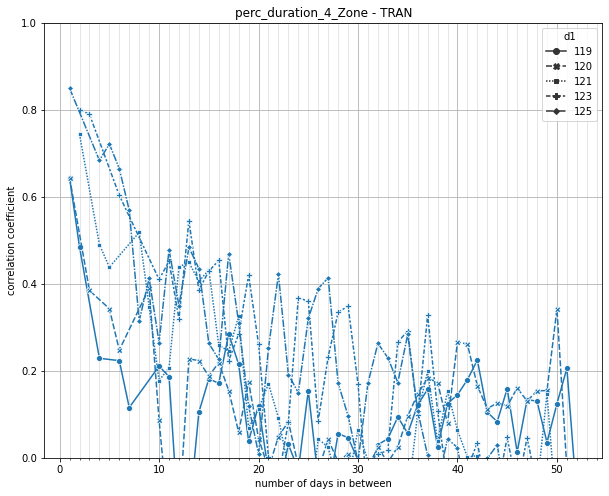

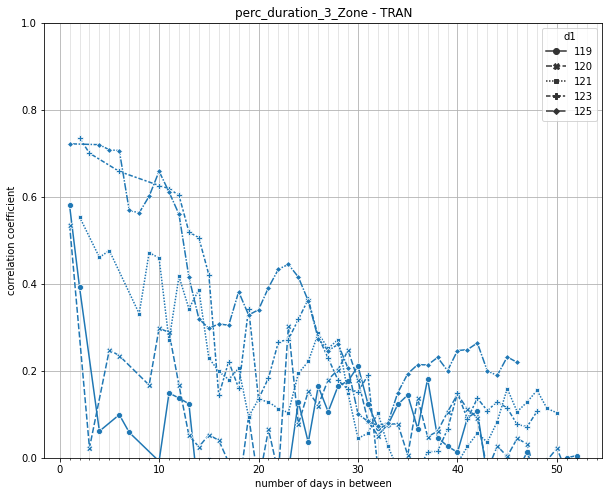

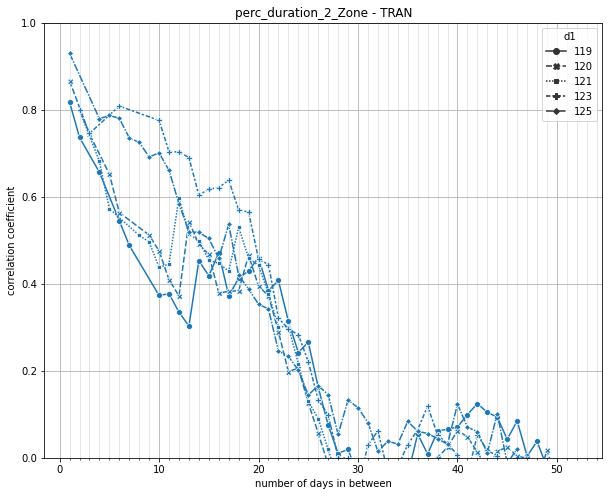

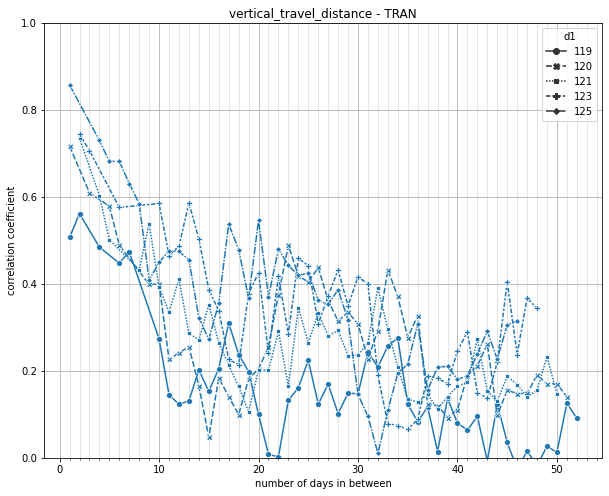

In [36]:
#nbr of "starting days" to be involved
nbr_starting_days = 7
for tr in df_corrddx['treatment'].unique():
    for type_ in df_corrddx['type_'].unique():
        fig = plt.figure(figsize=(10,8))
        plt.grid()
        graph = sns.lineplot(x='diff', y='coeff', data=df_corrddx[(df_corrddx['d1']<(min(li_DOA)+nbr_starting_days))&\
                                                                  (df_corrddx['type_']==type_)&\
                                                                  (df_corrddx['treatment']==tr)], 
                             markers=True, style='d1', hue_order=list(range(119,min(li_DOA)+nbr_starting_days)));
        plt.xlabel('number of days in between')
        plt.ylabel('correlation coefficient')
        minor_ticks = np.arange(0, 55, 1)
        graph.set_xticks(minor_ticks, minor=True)
        graph.grid(which='minor', alpha=0.4)
        plt.title(type_+' - '+tr)
        plt.ylim((0,1))
        plt.savefig(os.path.join(path_extracted_data, 'Predictibility_MLPSdayx_MLPSdy_'+type_+'_'+tr+'.png'), dpi=300, format='png', 
                    bbox_inches='tight')
        plt.show()